In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from MFEA_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task
from MFEA_lib.model.mfea import *
from MFEA_lib.model.utils import saveModel, loadModel, compareModel
from MFEA_lib.tasks.function import AbstractFunc
from MFEA_lib.operators import CrossOver, Mutation, Selection
from MFEA_lib.operators.CrossOver import SBX_CrossOver
from MFEA_lib.operators.Selection import ElitismSelection
from MFEA_lib.operators.Mutation import Polynomial_Mutation, NoMutation
from MFEA_lib.tasks.Benchmark import CEC17_benchmark, GECCO20_benchmark_50tasks

In [2]:
class cus_MFEA(AbstractModel):
    def renderRMP(self, shape = None, title = None, figsize = None, dpi = 200):
        if figsize is None:
            figsize = (30, 30)
        if title is None:
            title = self.__class__.__name__
        if shape is None:
            shape = (int(np.ceil(len(self.tasks) / 3)), 3)
        else:
            assert shape[0] * shape[1] >= len(self.tasks)
        fig = plt.figure(figsize= figsize, dpi = dpi)
        fig.suptitle(title, size = 15)
        fig.set_facecolor("white")

        for i in range (len(self.tasks)):
            for j in range (len(self.tasks)):
                if i != j: 
                    plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
                    plt.plot(np.arange(len(self.saved_rmp[i][j])), np.array(self.saved_rmp[i][j])[:, 0], label= 'task: ' +str(j + 1))
                    plt.legend()
                else:
                    plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
                    plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
                    plt.legend()

            plt.title('task ' + str( i + 1))
            plt.xlabel("Epoch")
            plt.ylabel("M_rmp")
            plt.ylim(bottom = -0.1, top = 1.1)

        return fig

    def success_history_memory_update(self, memory_M:np.ndarray, next_pos: np.ndarray, S: list, delta: list):
        for i in range(len(self.tasks)):
            for j in range(len(self.tasks)):
                if len(S[i][j]) != 0:
                    memory_M[i, j][next_pos[i][j]] =\
                        np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)

                    next_pos[i, j] = (next_pos[i, j] + 1) % memory_M.shape[2]
        return memory_M, next_pos
    
    def findParent(self, idx_parents, pop_fcost, type = None):
        if type == 'intra':
            idx_p1, idx_p2 = np.random.choice(idx_parents, size= 2, replace= False)
            return (idx_p1, idx_p2)[np.argmin([pop_fcost[idx_p1], pop_fcost[idx_p2]])]
        elif type == 'inter':
            idx = np.random.choice(idx_parents)
            return idx
        else:
            raise ValueError()

    def compile(self, cross_over = CrossOver.SBX_CrossOver(), mutation=  Mutation.Polynomial_Mutation(), selection= Selection.ElitismSelection()):
        super().compile(cross_over, mutation, selection)
    
    def fit(self, tasks: list[AbstractFunc], num_epochs, num_inds_each_task=100, nb_inds_min = None, H = 30, sigmoid = 0.1,
                evaluate_initial_skillFactor=True, range_init_pop= [0, 1]) -> tuple[list[np.ndarray], np.ndarray]:
                
        # LSA or SA
        if nb_inds_min is not None:
            assert num_inds_each_task >= nb_inds_min
        else:
            nb_inds_min = num_inds_each_task
            
        self.tasks = tasks

        # initial history of factorial cost -> for render
        self.history_cost = np.empty((0, len(tasks)), np.float) 

        # dim of Unified search space
        dim_uss = max([t.dim for t in tasks])

        # initial population
        inf, sup = range_init_pop
        population, skill_factor_arr = population_init(
            N = num_inds_each_task,
            num_tasks= len(tasks),
            d = dim_uss,
            min_val= inf,
            max_val= sup
        )

        if evaluate_initial_skillFactor:
            skill_factor_arr = skill_factor_best_task(population, tasks)
        pop_fcost = factorial_cost(population, skill_factor_arr, tasks)
        pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))

        # SA params:
        MAXEVALS = num_epochs * num_inds_each_task * len(tasks)
        eval_k = np.zeros(len(tasks))
        epoch = 0

        # Initial success history memory M_rmp
        M_rmp = np.ones((len(tasks), len(tasks), H))/2
        next_update_pos_M_rmp = np.zeros((len(tasks), len(tasks)), np.int)

        # mean and std of rmp each generations
        # len(tasks) * len(tasks) * generations * 2
        self.saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()

        # save history_cost
        self.history_cost = np.append(self.history_cost, 
            [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
            axis = 0
        )
        epoch = 1

        # hisory rmp of this generation
        rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

        while np.sum(eval_k) <= MAXEVALS:

            # S, delta rmp
            S_rmp = np.empty((len(tasks), len(tasks), 0)).tolist()
            delta_rmp = np.empty((len(tasks), len(tasks), 0)).tolist()

            # initial offspring of generation
            offspring = np.empty((0, dim_uss))
            offspring_skill_factor = np.empty((0, ), np.int)
            offspring_fcost = np.empty((0, ))

            while len(offspring) < len(population):
                skf_pa, skf_pb = np.random.choice(np.arange(len(tasks)), size = 2, replace= False)          

                if np.sum(eval_k) >= epoch * num_inds_each_task * len(tasks):
                    #save history
                    self.history_cost = np.append(self.history_cost, 
                        [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
                        axis = 0
                    ) 

                    # save mean and std rmp
                    for i in range(len(tasks)):
                        for j in range(len(tasks)):
                            if len(rmp_this_gen[i][j]) != 0:
                                mu = np.mean(rmp_this_gen[i][j])
                                std = np.std(rmp_this_gen[i][j])
                                self.saved_rmp[i][j].append([mu, std])

                    # hisory rmp of this generation
                    rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

                    #print
                    sys.stdout.write('\r')
                    sys.stdout.write('Epoch {}, [%-20s] %3d%% ,pop_size: {}, func_val: {}'
                        .format(epoch, len(population),[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                        % ('=' * np.int((np.sum(eval_k) + 1) // (MAXEVALS // 20)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
                        )
                    sys.stdout.flush()

                    epoch += 1

                # get rmp
                mu = np.random.choice(M_rmp[skf_pa, skf_pb])
                rmp = -1
                while rmp <= 0:
                    rmp = np.random.normal(mu, sigmoid)
                if rmp > 1: rmp = 1

                # save generation's rmp
                rmp_this_gen[skf_pa][skf_pb].append(rmp)

                # Inter-TaskCrossover
                if np.random.uniform() < rmp * (len(tasks) - 1)/len(tasks):
                    
                    #find parent
                    idx_pa = self.findParent(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, type = 'inter')
                    idx_pb = self.findParent(np.where(skill_factor_arr == skf_pb)[0], pop_fcost, type = 'inter')

                    pa, pb = population[idx_pa], population[idx_pb]

                    oa, ob = self.cross_over(pa, pb, 'inter1skf', 0.1)
                    oa, ob = self.mutation(oa), self.mutation(ob)
                    #NOTE
                    if skf_pa == 7:
                        oa, ob = Polynomial_Mutation(5)(oa), Polynomial_Mutation(5)(ob)
                    skf_oa, skf_ob = skf_pa, skf_pa

                    # Evaluate oa, ob
                    fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)

                    # Calculate the maximum improvement percetage
                    Delta = max(0, 
                        (pop_fcost[idx_pa] - fcost_oa)/(pop_fcost[idx_pa] + 1e-10),
                        (pop_fcost[idx_pa] - fcost_ob)/(pop_fcost[idx_pa] + 1e-10)
                    )

                # Intra-TaskCrossover
                else:
                    idx_pa = self.findParent(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, type = 'intra')
                    idx_pa2 = self.findParent(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, type = 'intra')

                    pa, pa2 = population[idx_pa], population[idx_pa2]

                    oa, ob = self.cross_over(pa, pa2, type= 'intra')
                    oa, ob = self.mutation(oa), self.mutation(ob)
                    #NOTE
                    if skf_pa == 7:
                        oa, ob = Polynomial_Mutation(5)(oa), Polynomial_Mutation(5)(ob)
                    skf_oa, skf_ob = skf_pa, skf_pa

                    # Evaluate oa, ob
                    fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)

                    # Calculate the maximum improvement percetage
                    Delta = max(0, 
                            (min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) - fcost_oa)/(min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) + 1e-100),
                            (min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) - fcost_ob)/(min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) + 1e-100)
                    )
                    
                if Delta > 0:
                    S_rmp[skf_pa][skf_pb].append(rmp)
                    delta_rmp[skf_pa][skf_pb].append(Delta)
                
                eval_k[skf_oa] += 1
                eval_k[skf_ob] += 1
                offspring = np.append(offspring, [oa, ob], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob], axis = 0)
                offspring_fcost = np.append(offspring_fcost, [fcost_oa, fcost_ob], axis = 0)

            # update succes history memory 
            M_rmp, next_update_pos_M_rmp = self.success_history_memory_update(M_rmp, next_update_pos_M_rmp, S_rmp, delta_rmp)

            # merge
            population = np.append(population, offspring, axis = 0)
            skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
            pop_fcost = np.append(pop_fcost, offspring_fcost, axis = 0)

            # selection
            pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
            nb_inds_tasks = [int(min((nb_inds_min - num_inds_each_task)/num_epochs * epoch + num_inds_each_task, num_inds_each_task))]*len(tasks)
            idx = self.selection(skill_factor_arr, pop_fitness, nb_inds_tasks= nb_inds_tasks)

            population = population[idx]
            skill_factor_arr = skill_factor_arr[idx]
            pop_fcost = pop_fcost[idx]

        #solve
        sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
        self.solve = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

        return self.solve, self.history_cost


In [3]:
cec17_10tasks = CEC17_benchmark.get_10tasks_benchmark()

In [4]:
cus_model = cus_MFEA()

cus_model.compile(
    cross_over= SBX_CrossOver(nc = 2),
    # mutation= Polynomial_Mutation(nm = 30),
    mutation = NoMutation(),
    selection= ElitismSelection()
)

cus_sol, cus_his = cus_model.fit(tasks= cec17_10tasks, num_epochs= 1000, num_inds_each_task= 100, nb_inds_min = 100, H = 30, sigmoid = 0.1,
                    evaluate_initial_skillFactor= True)
saveModel(cus_model, "./RESULTS/cec17_cusMFEA.mso")


KeyboardInterrupt: 

In [6]:
cus_Lmodel = cus_MFEA()

cus_Lmodel.compile(
    cross_over= SBX_CrossOver(nc = 2),
    # mutation= Polynomial_Mutation(nm = 5),
    mutation = NoMutation(),
    selection= ElitismSelection()
)

cus_sol, cus_his = cus_Lmodel.fit(tasks= cec17_10tasks, num_epochs= 1000, num_inds_each_task= 100, nb_inds_min = 80, H = 30, sigmoid = 0.1,
                    evaluate_initial_skillFactor= True)
saveModel(cus_Lmodel, "./RESULTS/cec17_cusLMFEA.mso")


Epoch 1000, [====================>] 100% ,pop_size: 800, func_val: [3.6872605741349065e-22, 2.5703991300231778e-24, 0.0, 0.0, 9.280368400878142, 3.4861002973229915e-13, 0.0, 0.0006363826178130694, 0.014779776754825669, 67.65711503508595].65711503508595]] 67.65711503508595]65711511584135]]]]]

'Saved'

In [4]:
model1 = loadModel("./RESULTS/cec17_mfea1.mso")

base_model = loadModel("./RESULTS/cec17_mfeabase.mso")

sa_model = loadModel("./RESULTS/cec17_sa_mfea.mso")

lsa_model = loadModel("./RESULTS/cec17_lsa_mfea.mso")

cus_model:cus_MFEA = loadModel("./RESULTS/cec17_cusMFEA.mso")

cus_Lmodel:cus_MFEA = loadModel("./RESULTS/cec17_cusLMFEA.mso")

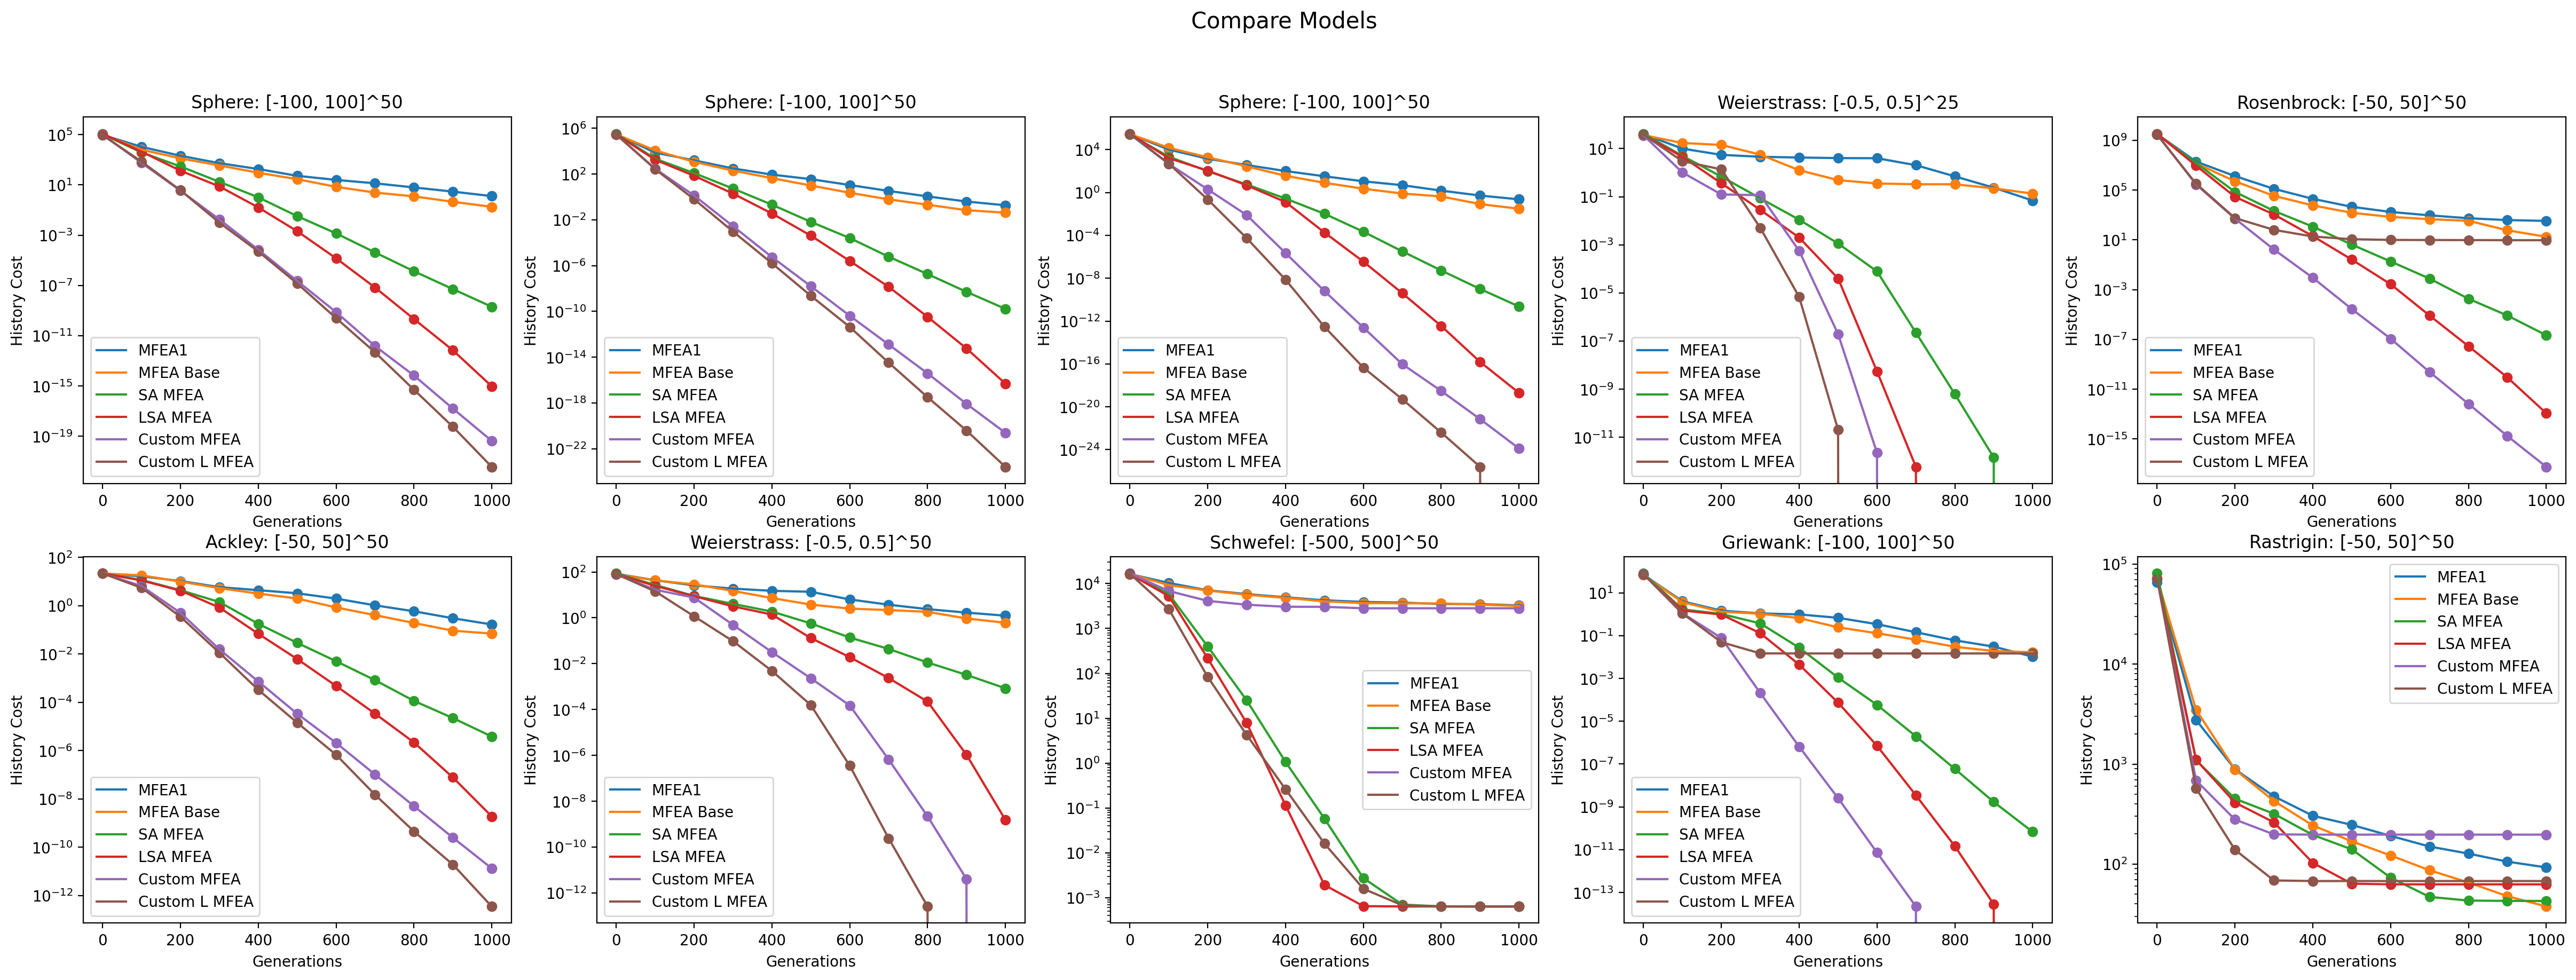

In [8]:
compareModel(
    models= [model1, base_model, sa_model, lsa_model, cus_model, cus_Lmodel],
    label_legend=  ["MFEA1", "MFEA Base", "SA MFEA", "LSA MFEA", "Custom MFEA", "Custom L MFEA"],
    tasks= cec17_10tasks,
    shape= (2, 5),
    step= 100,
    yscale= 'log'
)
print()

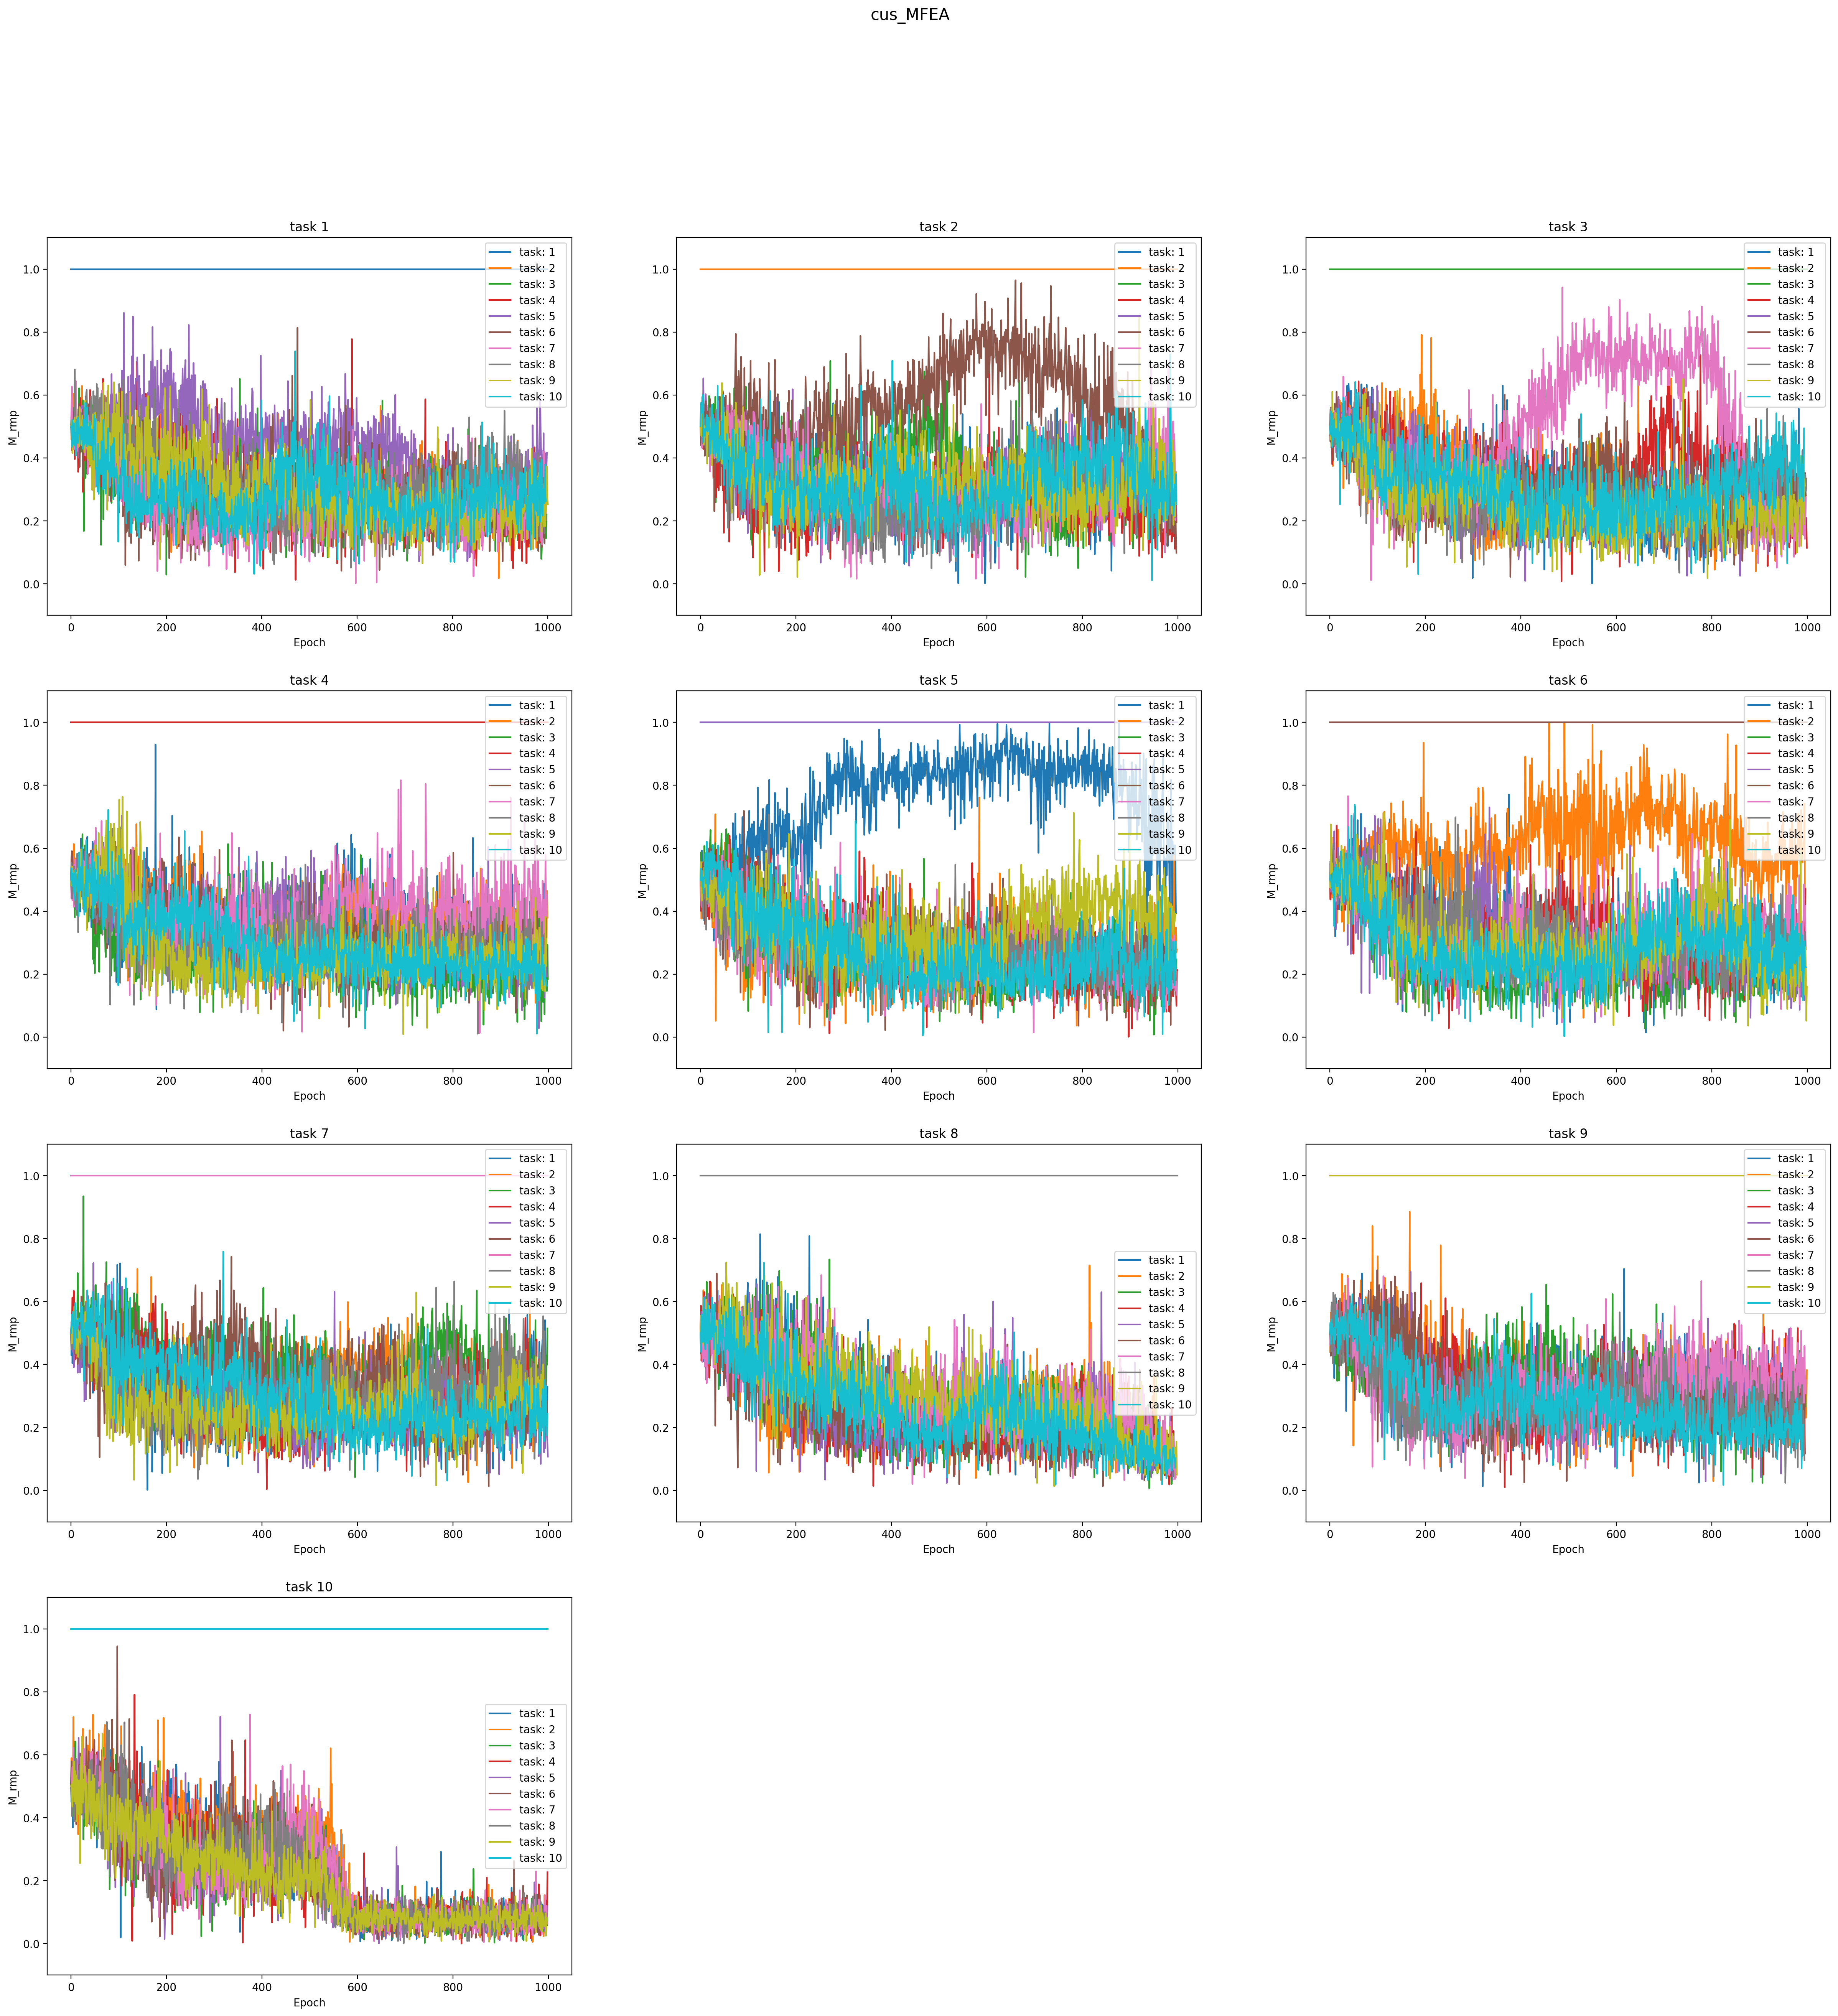

In [9]:
cus_model.renderRMP()
print()